In [ ]:
import sys
sys.path.append('../')

import os
import re
import json
import click
import torch
import dnnlib
from torch_utils import distributed as dist
from training import training_loop

import matplotlib.pyplot as plt
# import h5py
import numpy as np
from torch.utils.data import Dataset

sys.path.insert(0, '/Users/amyfang/Developer/3D_SR_CT')
import augmentation


In [6]:
class PatchDataset(Dataset):
    def __init__(self, hr_dir, if_translation=True, if_rotation=True, if_flip=True, if_downsample=True, flip_prob=0.5, tgt_patch_size=(48, 48, 48), curr_patch_size=(64, 64, 64)):
        self.hr_dir = hr_dir
        # store full patch paths
        self.hr_paths = []
        # store corresponding image names
        self.hr_img_names = []

        for image_folder in os.listdir(hr_dir):
            image_path = os.path.join(hr_dir, image_folder)

            # Ensure it's a directory
            if os.path.isdir(image_path):
                for patch in os.listdir(image_path):
                    patch_path = os.path.join(image_path, patch)

                    if os.path.isfile(patch_path):
                        self.hr_paths.append(patch_path)
                        self.hr_img_names.append(image_folder)
        
        # augmentation args
        self.translation = if_translation
        self.rotation = if_rotation
        self.flip = if_flip
        self.downsample = if_downsample
        self.flip_prob = flip_prob
        self.tgt_patch_size = tgt_patch_size
        self.curr_patch_size = curr_patch_size

    def __len__(self):
        return len(self.hr_paths)

    def augment(self, hr_patch):
        aug_patch = hr_patch
        if self.translation:
            aug_patch = augmentation.translation(aug_patch, self.tgt_patch_size, self.curr_patch_size)
        if self.rotation:
            aug_patch = augmentation.rotation(aug_patch)
        if self.flip:
            aug_patch = augmentation.flip(aug_patch, self.flip_prob)
        if self.downsample:
            aug_patch = augmentation.downsample(aug_patch)
        return aug_patch

    def __getitem__(self, index):
        hr_patch = np.load(self.hr_paths[index])
        aug_patch = self.augment(hr_patch)
        
        return torch.tensor(hr_patch, dtype = torch.float32), torch.tensor(aug_patch, dtype = torch.float32)



In [13]:
# read patches from patch folder
# Change this: '/Users/amyfang/Desktop/PennMed Lab/patches 2'
directory = "/Users/amyfang/Desktop/PennMed Lab/data"
print(directory)
train_data = PatchDataset(hr_dir = directory)

/Users/amyfang/Desktop/PennMed Lab/data


In [14]:
print("Dataset length:", len(train_data))
sample_hr, sample_lr = train_data[0]
print("Sample HR shape:", sample_hr.shape)
print("Sample LR shape:", sample_lr.shape)

Dataset length: 100
chosen_axis:  (0, 1)
axis:  0
scale:  3
Sample HR shape: torch.Size([64, 64, 64])
Sample LR shape: torch.Size([48, 48, 48])


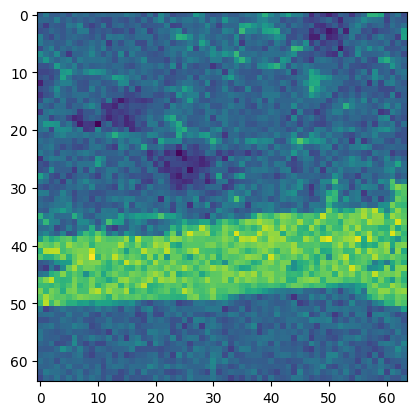

In [29]:
hr_np = sample_hr.numpy()

# Pick the middle slice along the depth dimension
d_hr = hr_np.shape[0] // 2
hr_slice = hr_np[d_hr, :, :]

plt.imshow(hr_slice)

In [15]:
from torch.utils.data import DataLoader

In [16]:
dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

- Input tensor: 1 * 64 * 64 * 64 -> 32
- Add cropping function in Dataset: hr
- Only use hr. (0:32 voxels)

In [17]:
for inputs, labels in dataloader:
    # inputs: BxC*H*W tensor, where C is channels, H and W are height and width of the patch
    # labels: Bx0 tensor (if no labels are used) or Bx1 tensor (if image names are used as labels)
    print(f'Input shape: {inputs.shape}, Label shape: {labels.shape}')


chosen_axis:  (0, 2)
axis:  1
scale:  4
chosen_axis:  (0, 2)
axis:  0
scale:  5
chosen_axis:  (1, 2)
axis:  1
scale:  5
chosen_axis:  (0, 1)
axis:  1
scale:  5
chosen_axis:  (0, 1)
scale:  3
chosen_axis:  (0, 1)
axis:  0
scale:  3
chosen_axis:  (0, 2)
axis:  1
scale:  5
chosen_axis:  (0, 1)
scale:  1
chosen_axis:  (0, 1)
scale:  3
chosen_axis:  (0, 2)
scale:  1
chosen_axis:  (0, 2)
axis:  2
scale:  2
chosen_axis:  (0, 2)
scale:  3
chosen_axis:  (1, 2)
axis:  0
scale:  2
chosen_axis:  (0, 2)
scale:  1
chosen_axis:  (1, 2)
scale:  4
chosen_axis:  (0, 1)
axis:  2
scale:  3
chosen_axis:  (1, 2)
scale:  1
chosen_axis:  (0, 2)
scale:  3
chosen_axis:  (1, 2)
axis:  1
scale:  5
chosen_axis:  (0, 2)
scale:  1
chosen_axis:  (0, 2)
axis:  1
scale:  3
chosen_axis:  (1, 2)
scale:  5
chosen_axis:  (0, 1)
axis:  2
scale:  2
chosen_axis:  (0, 1)
scale:  1
chosen_axis:  (0, 1)
axis:  0
scale:  4
chosen_axis:  (0, 1)
scale:  2
chosen_axis:  (1, 2)
scale:  4
chosen_axis:  (0, 2)
axis:  0
scale:  4
chosen

RuntimeError: stack expects each tensor to be equal size, but got [48, 48, 48] at entry 0 and [50, 50, 50] at entry 1

# Train on HR patches

In [ ]:
# Training a model
# Copyright (c) 2024, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
#
# This work is licensed under a Creative Commons
# Attribution-NonCommercial-ShareAlike 4.0 International License.
# You should have received a copy of the license along with this
# work. If not, see http://creativecommons.org/licenses/by-nc-sa/4.0/

"""Main training loop."""

import os
import time
import copy
import pickle
import psutil
import numpy as np
import torch
import dnnlib
from torch_utils import distributed as dist
from torch_utils import training_stats
from torch_utils import persistence
from torch_utils import misc
import shutil

#----------------------------------------------------------------------------
# Uncertainty-based loss function (Equations 14,15,16,21) proposed in the
# paper "Analyzing and Improving the Training Dynamics of Diffusion Models".

# @persistence.persistent_class
class EDM2Loss:
    def __init__(self, P_mean=-0.4, P_std=1.0, sigma_data=0.5):
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data

    def __call__(self, net, images, labels=None):
        rnd_normal = torch.randn([images.shape[0], 1, 1, 1, 1], device=images.device)
        sigma = (rnd_normal * self.P_std + self.P_mean).exp()
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        noise = torch.randn_like(images) * sigma
        denoised, logvar = net(images + noise, sigma, labels, return_logvar=True)
        loss = (weight / logvar.exp()) * ((denoised - images) ** 2) + logvar
        return loss

#----------------------------------------------------------------------------
# Learning rate decay schedule used in the paper "Analyzing and Improving
# the Training Dynamics of Diffusion Models".

def learning_rate_schedule(cur_nimg, batch_size, ref_lr=100e-4, ref_batches=70e3, rampup_Mimg=10):
    lr = ref_lr
    if ref_batches > 0:
        lr /= np.sqrt(max(cur_nimg / (ref_batches * batch_size), 1))
    if rampup_Mimg > 0:
        lr *= min(cur_nimg / (rampup_Mimg * 1e6), 1)
    return lr

#----------------------------------------------------------------------------
# EDM sampler from the paper
# "Elucidating the Design Space of Diffusion-Based Generative Models",
# extended to support classifier-free guidance.

def edm_sampler(
    net, noise, labels=None, gnet=None,
    num_steps=32, sigma_min=0.002, sigma_max=80, rho=7, guidance=1,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,
    dtype=torch.float32, randn_like=torch.randn_like,
):
    # Guided denoiser.
    def denoise(x, t):
        Dx = net(x, t, labels).to(dtype)
        if guidance == 1:
            return Dx
        ref_Dx = gnet(x, t).to(dtype)
        return ref_Dx.lerp(Dx, guidance)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=dtype, device=noise.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = noise.to(dtype) * t_steps[0]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        if S_churn > 0 and S_min <= t_cur <= S_max:
            gamma = min(S_churn / num_steps, np.sqrt(2) - 1)
            t_hat = t_cur + gamma * t_cur
            x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * randn_like(x_cur)
        else:
            t_hat = t_cur
            x_hat = x_cur

        # Euler step.
        d_cur = (x_hat - denoise(x_hat, t_hat)) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            d_prime = (x_next - denoise(x_next, t_next)) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)

    return x_next


In [ ]:
loss_fn = EDM2Loss(P_mean=-0.4, P_std=1.0, sigma_data=0.5)

In [ ]:
os.makedirs('../experiments/hr_patches', exist_ok=True)

In [ ]:
dataset_kwargs      = None
data_loader_kwargs  = dict(class_name='torch.utils.data.DataLoader', pin_memory=True, num_workers=2, prefetch_factor=2)
network_kwargs      = dict(class_name='training.networks_edm2.Precond')
loss_kwargs         = dict(class_name='training.training_loop.EDM2Loss')
optimizer_kwargs    = dict(class_name='torch.optim.Adam', betas=(0.9, 0.99))
lr_kwargs           = dict(func_name='training.training_loop.learning_rate_schedule')
ema_kwargs          = dict(class_name='training.phema.PowerFunctionEMA')

run_dir             = '../experiments/hr_patches'      # Output directory.
seed                = 0        # Global random seed.
batch_size          = 16        # Total batch size for one training iteration.
batch_gpu           = None     # Limit batch size per GPU. None = no limit.
total_nimg          = 8<<30    # Train for a total of N training images.
slice_nimg          = None     # Train for a maximum of N training images in one invocation. None = no limit.
status_nimg         = 128<<8  # Report status every N training images. None = disable.
snapshot_nimg       = 8<<16    # Save network snapshot every N training images. None = disable.
checkpoint_nimg     = 128<<16  # Save state checkpoint every N training images. None = disable.

loss_scaling        = 1        # Loss scaling factor for reducing FP16 under/overflows.
force_finite        = True     # Get rid of NaN/Inf gradients before feeding them to the optimizer.
cudnn_benchmark     = True     # Enable torch.backends.cudnn.benchmark?
device              = torch.device('cuda')

if os.path.exists(f'{run_dir}/'):
    shutil.rmtree(run_dir)
    os.makedirs(f'{run_dir}/')

# Initialize.
prev_status_time = time.time()
misc.set_random_seed(seed, dist.get_rank())
# torch.backends.cudnn.benchmark = cudnn_benchmark
torch.backends.cudnn.allow_tf32 = False
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = False

# Validate batch size.
batch_gpu_total = batch_size // dist.get_world_size()
if batch_gpu is None or batch_gpu > batch_gpu_total:
    batch_gpu = batch_gpu_total
num_accumulation_rounds = batch_gpu_total // batch_gpu
assert batch_size == batch_gpu * num_accumulation_rounds * dist.get_world_size()
assert total_nimg % batch_size == 0
assert slice_nimg is None or slice_nimg % batch_size == 0
assert status_nimg is None or status_nimg % batch_size == 0
assert snapshot_nimg is None or (snapshot_nimg % batch_size == 0 and snapshot_nimg % 1024 == 0)
assert checkpoint_nimg is None or (checkpoint_nimg % batch_size == 0 and checkpoint_nimg % 1024 == 0)

# Setup dataset, and network.
dist.print0('Loading dataset...')
# Pass in training dataset object.
dataset_obj = training_dataset

ref_image, ref_label = dataset_obj[0]
dist.print0('Constructing network...')
interface_kwargs = dict(img_resolution=ref_image.shape[-1], img_channels=ref_image.shape[1], label_dim=ref_label.shape[-1])
# Pass in network object.
net = net
net.train().requires_grad_(True).to(device)

# Print network summary.
if dist.get_rank() == 0:
    misc.print_module_summary(net, [
        torch.zeros([batch_gpu, net.img_channels, net.temporal_resolution, net.img_resolution, net.img_resolution], device=device), # ------------------------need to alter dimensions of module summary input--------------------------------
        torch.ones([batch_gpu], device=device),
        torch.zeros([batch_gpu, net.label_dim], device=device),
    ], max_nesting=2)

# Setup training state.
dist.print0('Setting up training state...')
state = dnnlib.EasyDict(cur_nimg=0, total_elapsed_time=0)
# ddp = torch.nn.parallel.DistributedDataParallel(net, device_ids=[device])
# loss_fn = dnnlib.util.construct_class_by_name(**loss_kwargs)
loss_fn = loss_fn
optimizer = dnnlib.util.construct_class_by_name(params=net.parameters(), **optimizer_kwargs)
ema = dnnlib.util.construct_class_by_name(net=net, **ema_kwargs) if ema_kwargs is not None else None

# Load previous checkpoint and decide how long to train.
checkpoint = dist.CheckpointIO(state=state, net=net, loss_fn=loss_fn, optimizer=optimizer, ema=ema)
checkpoint.load_latest(run_dir)
stop_at_nimg = total_nimg
if slice_nimg is not None:
    granularity = checkpoint_nimg if checkpoint_nimg is not None else snapshot_nimg if snapshot_nimg is not None else batch_size
    slice_end_nimg = (state.cur_nimg + slice_nimg) // granularity * granularity # round down
    stop_at_nimg = min(stop_at_nimg, slice_end_nimg)
assert stop_at_nimg > state.cur_nimg
dist.print0(f'Training from {state.cur_nimg // 1000} kimg to {stop_at_nimg // 1000} kimg:')
dist.print0()

# Main training loop.
dataset_sampler = misc.InfiniteSampler(dataset=dataset_obj, rank=dist.get_rank(), num_replicas=dist.get_world_size(), seed=seed, start_idx=state.cur_nimg)
dataset_iterator = iter(dnnlib.util.construct_class_by_name(dataset=dataset_obj, sampler=dataset_sampler, batch_size=batch_gpu, **data_loader_kwargs))
prev_status_nimg = state.cur_nimg
cumulative_training_time = 0
start_nimg = state.cur_nimg
stats_jsonl = None
while True:
    done = (state.cur_nimg >= stop_at_nimg)

    # Report status.
    if status_nimg is not None and (done or state.cur_nimg % status_nimg == 0) and (state.cur_nimg != start_nimg or start_nimg == 0):
        cur_time = time.time()
        state.total_elapsed_time += cur_time - prev_status_time
        cur_process = psutil.Process(os.getpid())
        cpu_memory_usage = sum(p.memory_info().rss for p in [cur_process] + cur_process.children(recursive=True))
        dist.print0(' '.join(['Status:',
            'kimg',         f"{training_stats.report0('Progress/kimg',                              state.cur_nimg / 1e3):<9.1f}",
            'time',         f"{dnnlib.util.format_time(training_stats.report0('Timing/total_sec',   state.total_elapsed_time)):<12s}",
            'sec/tick',     f"{training_stats.report0('Timing/sec_per_tick',                        cur_time - prev_status_time):<8.2f}",
            'sec/kimg',     f"{training_stats.report0('Timing/sec_per_kimg',                        cumulative_training_time / max(state.cur_nimg - prev_status_nimg, 1) * 1e3):<7.3f}",
            'maintenance',  f"{training_stats.report0('Timing/maintenance_sec',                     cur_time - prev_status_time - cumulative_training_time):<7.2f}",
            'cpumem',       f"{training_stats.report0('Resources/cpu_mem_gb',                       cpu_memory_usage / 2**30):<6.2f}",
            'gpumem',       f"{training_stats.report0('Resources/peak_gpu_mem_gb',                  torch.cuda.max_memory_allocated(device) / 2**30):<6.2f}",
            'reserved',     f"{training_stats.report0('Resources/peak_gpu_mem_reserved_gb',         torch.cuda.max_memory_reserved(device) / 2**30):<6.2f}",
        ]))
        cumulative_training_time = 0
        prev_status_nimg = state.cur_nimg
        prev_status_time = cur_time
        torch.cuda.reset_peak_memory_stats()

        # Flush training stats.
        training_stats.default_collector.update()
        if dist.get_rank() == 0:
            if stats_jsonl is None:
                stats_jsonl = open(os.path.join(run_dir, 'stats.jsonl'), 'at')
            fmt = {'Progress/tick': '%.0f', 'Progress/kimg': '%.3f', 'timestamp': '%.3f'}
            items = [(name, value.mean) for name, value in training_stats.default_collector.as_dict().items()] + [('timestamp', time.time())]
            items = [f'"{name}": ' + (fmt.get(name, '%g') % value if np.isfinite(value) else 'NaN') for name, value in items]
            stats_jsonl.write('{' + ', '.join(items) + '}\n')
            stats_jsonl.flush()

        # Update progress and check for abort.
        dist.update_progress(state.cur_nimg // 1000, stop_at_nimg // 1000)
        if state.cur_nimg == stop_at_nimg and state.cur_nimg < total_nimg:
            dist.request_suspend()
        if dist.should_stop() or dist.should_suspend():
            done = True
            
        # Validate.
        with torch.no_grad():
            net.eval()
            noise = torch.randn([1, net.img_channels, net.temporal_resolution, net.img_resolution, net.img_resolution], device=device)
            labels = torch.eye(net.label_dim, device=device)[torch.randint(net.label_dim, size=[1], device=device)]
            samples = edm_sampler(net, noise, labels=labels, num_steps=32, sigma_min=0.002, sigma_max=80, rho=7, guidance=1,
                        S_churn=0, S_min=0, S_max=float('inf'), S_noise=1, dtype=torch.float32, randn_like=torch.randn_like)
            np.save(f'{run_dir}/samples_{str(state.cur_nimg//1024).zfill(6)}.npy', samples.detach().cpu().numpy())
            net.train()
            

    # Save network snapshot.
    if snapshot_nimg is not None and state.cur_nimg % snapshot_nimg == 0 and (state.cur_nimg != start_nimg or start_nimg == 0) and dist.get_rank() == 0:
        ema_list = ema.get() if ema is not None else optimizer.get_ema(net) if hasattr(optimizer, 'get_ema') else net
        ema_list = ema_list if isinstance(ema_list, list) else [(ema_list, '')]
        for ema_net, ema_suffix in ema_list:
            data = dnnlib.EasyDict(dataset_kwargs=dataset_kwargs, loss_fn=loss_fn)
            data.ema = copy.deepcopy(ema_net).cpu().eval().requires_grad_(False).to(torch.float16)
            fname = f'network-snapshot-{state.cur_nimg//1000:07d}{ema_suffix}.pkl'
            dist.print0(f'Saving {fname} ... ', end='', flush=True)
            with open(os.path.join(run_dir, fname), 'wb') as f:
                pickle.dump(data, f)
            dist.print0('done')
            del data # conserve memory

    # Save state checkpoint.
    if checkpoint_nimg is not None and (done or state.cur_nimg % checkpoint_nimg == 0) and state.cur_nimg != start_nimg:
        checkpoint.save(os.path.join(run_dir, f'training-state-{state.cur_nimg//1000:07d}.pt'))
        misc.check_ddp_consistency(net)

    # Done?
    if done:
        break

    # Evaluate loss and accumulate gradients.
    batch_start_time = time.time()
    misc.set_random_seed(seed, dist.get_rank(), state.cur_nimg)
    optimizer.zero_grad(set_to_none=True)

    iteration_losses = []

    for round_idx in range(num_accumulation_rounds):
        # with misc.ddp_sync(ddp, (round_idx == num_accumulation_rounds - 1)):
        images, labels = next(dataset_iterator)
        images = images.to(device)
        # loss = loss_fn(net=ddp, images=images, labels=labels.to(device))
        loss = loss_fn(net=net, images=images, labels=labels.to(device))

        # record the loss value
        iteration_losses.append(loss)

        training_stats.report('Loss/loss', loss)
        loss.sum().mul(loss_scaling / batch_gpu_total).backward()

    # Run optimizer and update weights.
    lr = dnnlib.util.call_func_by_name(cur_nimg=state.cur_nimg, batch_size=batch_size, **lr_kwargs)
    training_stats.report('Loss/learning_rate', lr)
    for g in optimizer.param_groups:
        g['lr'] = lr
    if force_finite:
        for param in net.parameters():
            if param.grad is not None:
                torch.nan_to_num(param.grad, nan=0, posinf=0, neginf=0, out=param.grad)
    optimizer.step()

    # Update EMA and training state.
    state.cur_nimg += batch_size
    if ema is not None:
        ema.update(cur_nimg=state.cur_nimg, batch_size=batch_size)
    cumulative_training_time += time.time() - batch_start_time
#----------------------------------------------------------------------------

In [ ]:
# plot loss history
plt.figure(figsize = (10, 5))
plt.plot(iteration_losses, label = 'Iteration Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
sample = np.load('/home/trevor/repos/video_edm2/experiments/mnist_test/samples_027904_99339602063455575688133065481878134393250160843453077890448214290674994981349861913707152312216145464973274376175502395242759439.npy')
sample.shape
plt.imshow(sample[0,0,:,:,8])
import mrcfile
mrcfile.write('/home/trevor/repos/video_edm2/experiments/mnist_test/samples_027904_99339602.mrc', sample[:8,0], overwrite=True)
integers = torch.randint(10, size=[5], device=torch.device('cuda'))
